In [25]:
from StorageModel import StorageModel
from mesa.batchrunner import batch_run

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc, colors
rc('animation', html='jshtml')

import numpy as np
import pandas as pd
import seaborn as sns


from IPython import display

In [2]:
MAX_STEPS = 15000000
GRID_WIDTH = 20
GRID_HEIGH = 20
N_EXPLORERS = 2
N_COLELCTORS = 3
MAX_FOOD = 47

In [3]:
model = StorageModel((GRID_WIDTH, GRID_HEIGH),
                     (N_EXPLORERS, N_COLELCTORS), MAX_FOOD, True)

for _ in range(MAX_STEPS):
    model.step()
    if not model.running:
        break

In [4]:
data = model.datacollector.get_model_vars_dataframe()
print(len(data))

421


In [5]:
def animate(data):
    fig, axs = plt.subplots(figsize=(3, 3))
    axs.set_xticks([])
    axs.set_yticks([])
    patch = plt.imshow(data[len(data) - 1], cmap=plt.cm.binary)
    plt.clim(0, 3)
    plt.close()
    anim = animation.FuncAnimation(
        fig, lambda i: patch.set_data(data[i]), frames=len(data))
    render = anim.to_jshtml()

    return render

In [6]:

known = data.get("Known")
real = data.get("Real")
agents = data.get("Agents")

r1 = animate(known)
r2 = animate(real)
r3 = animate(agents)

In [7]:
display.HTML(r1)

In [8]:
display.HTML(r2)

In [9]:
display.HTML(r3)

In [10]:
changing_food = batch_run(StorageModel, {
    "shape": [(GRID_WIDTH, GRID_HEIGH)],
    "agents": [(2, 3)],
    "max_food": range(MAX_FOOD*2),
    "render": [False],
    "simulating": [True]
}, max_steps=MAX_STEPS, number_processes=None, display_progress=True, iterations=50)

  0%|          | 0/4700 [00:00<?, ?it/s]

In [49]:

# changing_food.sort(key=lambda x: x.get("max_food"))
food_df = pd.DataFrame(changing_food)
food_df = food_df[['Steps', 'max_food']]
food_df = food_df.groupby("max_food").mean()


In [14]:
shapes = list(zip(range(GRID_WIDTH, GRID_WIDTH * 5), range(GRID_WIDTH, GRID_WIDTH * 5)))
changing_size = batch_run(StorageModel, {
    "shape": shapes,
    "agents": [(2, 3)],
    "max_food": MAX_FOOD,
    "render": [False],
    "simulating": [True]
}, max_steps=MAX_STEPS, number_processes=None, display_progress=True, iterations=10)

  0%|          | 0/800 [00:00<?, ?it/s]

In [48]:
size_df = pd.DataFrame(changing_size)
size_df["area"] = size_df["shape"].map(lambda x: x[0] * x[1])
size_df = size_df[['Steps', 'area']]
size_df = size_df.groupby("area").mean()

In [22]:
agents_counts = []

for i in range(2, 20):
    agents = list(zip(range(1, min(GRID_HEIGH, i)), reversed(range(1, i))))
    agents_counts.extend(agents)

agents_counts = list(set(agents_counts))

# print(agents_counts)
changing_agents = batch_run(StorageModel, {
    "shape": [(GRID_WIDTH, GRID_HEIGH)],
    "agents": agents_counts,
    "max_food": MAX_FOOD,
    "render": [False],
    "simulating": [True]
}, max_steps=MAX_STEPS, number_processes=None, display_progress=True, iterations=50)

  0%|          | 0/8550 [00:00<?, ?it/s]

In [61]:
agents_df = pd.DataFrame(changing_agents)
agents_df["total_agents"] = agents_df["agents"].map(lambda x: x[0] + x[1])
agents_df["ratio"] = agents_df["agents"].map(lambda x: x[0] / (x[0] + x[1]))
agents_df = agents_df[['Steps', 'ratio', 'total_agents']]

In [62]:
agents2_df = pd.DataFrame(changing_agents)
agents2_df["Explorers"] = agents2_df["agents"].map(lambda x: x[0])
agents2_df["Collectors"] = agents2_df["agents"].map(lambda x: x[1])
agents2_df = agents2_df[['Steps', 'Explorers', 'Collectors']]
heatmap2_df = agents2_df.groupby(['Explorers', 'Collectors']).mean().reset_index()
heatmap2_df = heatmap2_df.pivot(index='Explorers', columns='Collectors', values='Steps')


<Axes: xlabel='max_food'>

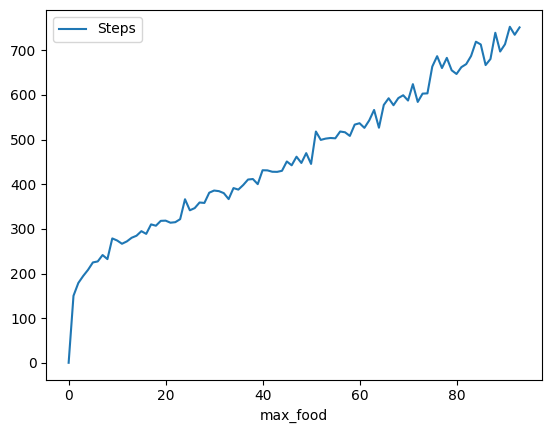

In [71]:
food_df.plot()

<Axes: xlabel='area'>

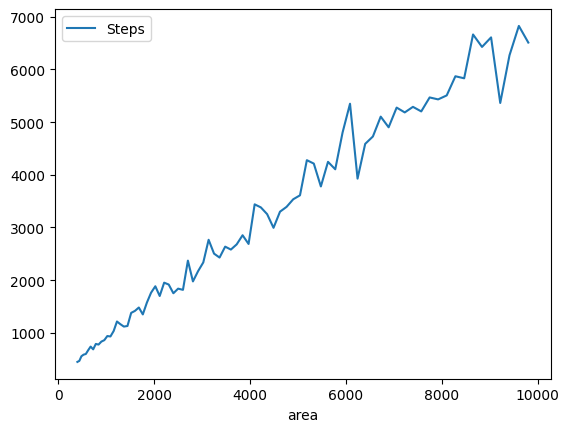

In [72]:
size_df.plot()

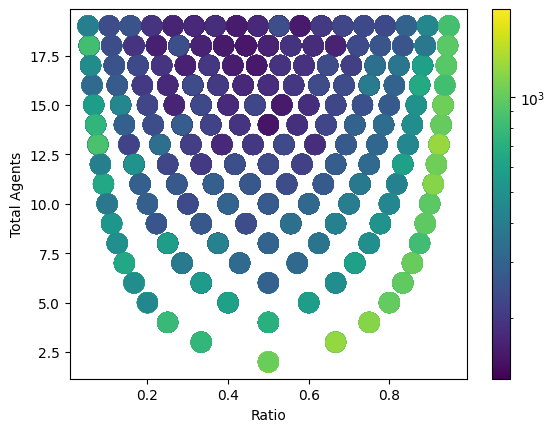

In [73]:
# Agents 1
plt.scatter(agents_df["ratio"], agents_df["total_agents"], c=agents_df["Steps"], cmap="viridis", norm=colors.LogNorm(), s=200)
plt.xlabel("Ratio")
plt.ylabel("Total Agents")
plt.colorbar()

<Axes: xlabel='Collectors', ylabel='Explorers'>

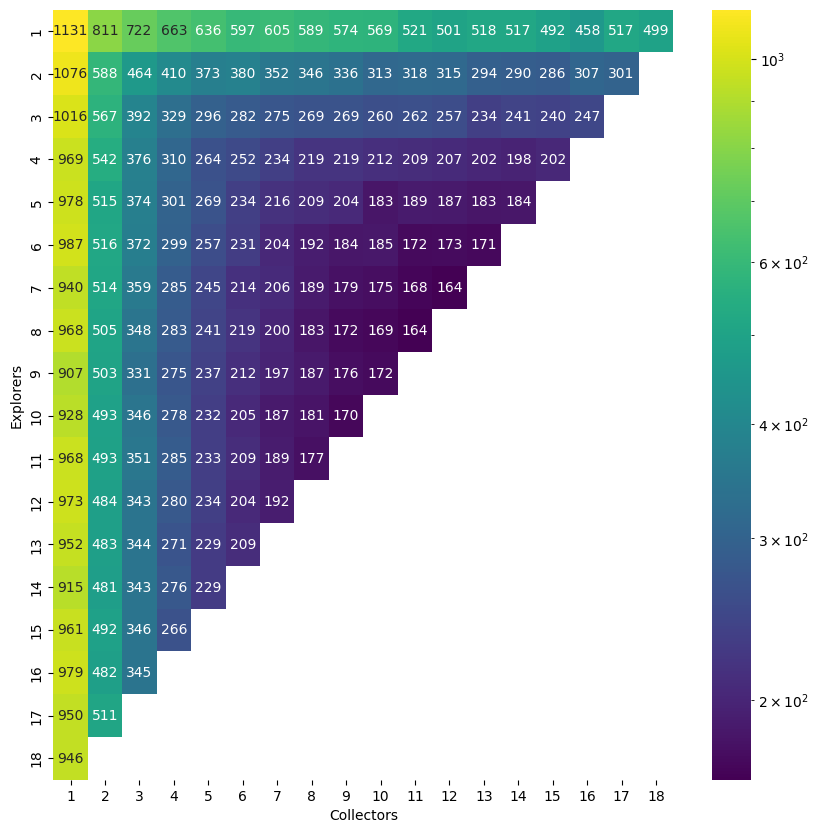

In [74]:
# Agents 2
plt.figure(figsize=(10, 10))

sns.heatmap(heatmap2_df, annot=True, fmt=".0f", cmap="viridis", norm=colors.LogNorm())
plt.gca().invert_yaxis()
